In [1]:
from collections import OrderedDict
import h5py
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pickle
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score
import statsmodels.nonparametric.api as smnp

from util import roc_curve_plot
from util import bootstrap
from util import balance_classes

from matplotlib import rcParams

%matplotlib inline

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [29]:
predictions_dir = "predict_output/"
train_dir = ""
test_dir = ""
save_dir = "figures/"

DATA = {
    'KaggleDR_train':
        {'LABELS_FILE': train_dir + 'trainLabels.csv',
         'IMAGE_PATH': train_dir,
         'LEVEL': OrderedDict([(0, 'no DR'),
                               (1, 'mild DR'),
                               (2, 'moderate DR'),
                               (3, 'severe DR'),
                               (4, 'proliferative DR')]),
         'min_percentile': 50,
         'n_bootstrap': 10000},
    'KaggleDR':
        {'LABELS_FILE': test_dir + 'testLabels.csv',
         'IMAGE_PATH': test_dir,
         'LEVEL': OrderedDict([(0, 'no DR'),
                               (1, 'mild DR'),
                               (2, 'moderate DR'),
                               (3, 'severe DR'),
                               (4, 'proliferative DR')]),
         'min_percentile': 0,
         'n_bootstrap': 10000},
    'Messidor':
        {'LABELS_FILE': 'messidor.csv',
         'IMAGE_PATH': 'data/messidor/JF_512',
         'LEVEL': OrderedDict([(0, 'no DR'),
                               (1, 'mild non-proliferative DR'),
                               (2, 'severe non-proliferative DR'),
                               (3, 'most serious')]),
         'min_percentile': 0,
         'n_bootstrap': 10000}
}

In [16]:
CONFIG = {
    'BCNN_mildDR_Kaggle_train': dict(
        [('net', 'BCNN'),
         ('dataset', 'Kaggle train'),
         ('predictions', predictions_dir +
          'mc_100_kaggledr_0vs1234_bcnn.pkl'), # this is test
         ('disease_onset', 1)] + list(
        DATA['KaggleDR_train'].items())),

    'BCNN_mildDR_Kaggle': dict(
        [('net', 'BCNN'),
         ('dataset', 'Kaggle'),
         ('predictions', predictions_dir + 
          'full_mc_100_kaggledr_0vs1234_bcnn.pkl'),
         ('disease_onset', 1)] + list(
        DATA['KaggleDR'].items())),

    'BCNN_moderateDR_Kaggle': dict(
        [('net', 'BCNN'),
         ('dataset', 'Kaggle'),
         ('predictions', predictions_dir +
          'full_mc_100_kaggledr_01vs234_bcnn.pkl'),
         ('disease_onset', 2)] + list(
        DATA['KaggleDR'].items())),

    'JFnet_mildDR_Kaggle': dict(
        [('net', 'JFnet'),
         ('dataset', 'Kaggle'),
         ('predictions', predictions_dir + 
          'mc_100_kaggledr_jfnet.pkl'),
         ('disease_onset', 1)] + list(
        DATA['KaggleDR'].items())),

    'JFnet_moderateDR_Kaggle': dict(
        [('net', 'JFnet'),
         ('dataset', 'Kaggle'),
         ('predictions', predictions_dir + 
          'mc_100_kaggledr_jfnet.pkl'),
         ('disease_onset', 2)] + list(
        DATA['KaggleDR'].items())),
  
    'BCNN_mildDR_Messidor': dict(
        [('net', 'BCNN'),
         ('dataset', 'Messidor'),
         ('predictions', predictions_dir + 
          'mc_100_messidor_bcnn_0vs1234.pkl'),
         ('disease_onset', 1)] +list(
        DATA['Messidor'].items())),
    
    'BCNN_moderateDR_Messidor': dict(
        [('net', 'BCNN'),
         ('dataset', 'Messidor'),
         ('predictions', predictions_dir + 
          'mc_100_messidor_bcnn_01vs234.pkl'),
         ('disease_onset', 2)] +list(
        DATA['Messidor'].items()))
}

In [17]:
# ---- FIGURE PARAMETERS -----
rcParams.update({'figure.autolayout': True})

plt.ion()
sns.set_context('paper', font_scale=2)
sns.set_style('whitegrid')

FIGURE_WIDTH = 8.27 * 1.5 # 8.27 inch corresponds to A4

TAG = {0: 'healthy', 1: 'diseased'}
ONSET_TAG = {1: 'mild DR', 2: 'moderate DR'}

In [18]:
# ----- UTIL FUNCTIONS ------

# Set nrows to None later!
def load_labels(labels_file, nrows=9600):
    df_test = pd.read_csv(labels_file, nrows=nrows)
    y_test = df_test.level.values
    return y_test


def load_filenames(labels_file):
    df_test = pd.read_csv(labels_file)
    return df_test.image.values


def load_predictions(filename):
    """Load test predictions obtained with scripts/predict.py"""
    with open(filename, 'rb') as h:
        pred_test = pickle.load(h)
    probs = pred_test['det_out']
    probs_mc = pred_test['stoch_out']
    assert ((0.0 <= probs) & (probs <= 1.0 + 1e-6)).all()
    assert ((0.0 <= probs_mc) & (probs_mc <= 1.0 + 1e-6)).all()
    return probs, probs_mc


def binary_labels(labels, min_positive_level=1):
    labels_bin = np.zeros_like(labels)
    labels_bin[labels < min_positive_level] = 0
    labels_bin[labels >= min_positive_level] = 1
    return labels_bin


def binary_probs(probs, min_positive_level=1):
    n_classes = probs.shape[1]
    if n_classes == 5:
        return probs[:, min_positive_level:].sum(axis=1)
    elif n_classes == 2:
        return np.squeeze(probs[:, 1:])
    else:
        print('Unknown number of classes: %d. Aborting.' % n_classes)


def binary_entropy(p):
    assert p.ndim == 1
    return -(p * np.log2(p + 1e-6) + (1 - p) * np.log2((1 - p) + 1e-6))


def detection_task(y, probs, probs_mc, disease_level):
    y_diseased = binary_labels(y, disease_level)
    probs_diseased = binary_probs(probs, disease_level)
    probs_mc_diseased = binary_probs(probs_mc, disease_level)
    return y_diseased, probs_diseased, probs_mc_diseased


def mode(data):
    """Compute a kernel density estimate and return the mode"""
    if len(np.unique(data)) == 1:
        return data[0]
    else:
        kde = smnp.KDEUnivariate(data.astype('double'))
        kde.fit(cut=0)
        grid, y = kde.support, kde.density
        return grid[y == y.max()][0]


def posterior_statistics(probs_mc_bin):
    predictive_mean = probs_mc_bin.mean(axis=1)
    predictive_std = probs_mc_bin.std(axis=1)
    assert (0.0 <= predictive_std).all()
    return predictive_mean, predictive_std


def argmax_labels(probs):
    return (probs >= 0.5).astype(int)


def accuracy(y_true, probs):
    y_pred = argmax_labels(probs)
    assert len(y_true) == len(y_pred)
    return (y_true == y_pred).sum() / float(len(y_true))


def rel_freq(y, k):
    return (y == k).sum() / float(len(y))


def contralateral_agreement(y, config):
    """Get boolean array of contralateral label agreement

    Notes
    =====

    A very similar function is already there in datasets.py but here we want
    to work on indices and more importantly check for contralateral label
    agreement for a potentially binary label vector y for the corresponding
    disease detection problem.

    """

    if 'kaggle_dr' not in config['LABELS_FILE']:
        raise TypeError('Laterality not defined for %s'
                        % config['LABELS_FILE'])

    df = pd.read_csv(config['LABELS_FILE'])
    left = df.image.str.contains(r'\d+_left').values
    right = df.image.str.contains(r'\d+_right').values

    accepted_patients = (y[left] == y[right])
    accepted_images_left = df[left].image[accepted_patients]
    accepted_images_right = df[right].image[accepted_patients]
    accepted_images = pd.concat((accepted_images_left,
                                 accepted_images_right))
    return df.image.isin(accepted_images).values


def performance_over_uncertainty_tol(uncertainty, y, probs, measure,
                                     min_percentile, n_bootstrap):

    uncertainty_tol, frac_retain, accept_idx = \
        sample_rejection(uncertainty, min_percentile)

    p = np.zeros((len(uncertainty_tol),), dtype=[('value', 'float64'),
                                                 ('low', 'float64'),
                                                 ('high', 'float64')])
    p_rand = np.zeros((len(uncertainty_tol),), dtype=[('value', 'float64'),
                                                      ('low', 'float64'),
                                                      ('high', 'float64')])

    for i, ut in enumerate(uncertainty_tol):
        accept = accept_idx[i]
        rand_sel = np.random.permutation(accept)

        low, high = bootstrap([y[accept], probs[accept]], measure,
                              n_resamples=n_bootstrap, alpha=0.05)

        p['value'][i] = measure(y[accept], probs[accept])
        p['low'][i] = low.value
        p['high'][i] = high.value

        low, high = bootstrap([y[rand_sel], probs[rand_sel]], measure,
                              n_resamples=100, alpha=0.05)

        p_rand['value'][i] = measure(y[rand_sel], probs[rand_sel])
        p_rand['low'][i] = low.value
        p_rand['high'][i] = high.value

    return uncertainty_tol, frac_retain, p, p_rand


def sample_rejection(uncertainty, min_percentile,
                     maximum=None):
    if maximum is None:
        maximum = uncertainty.max()
    uncertainty_tol = np.linspace(np.percentile(uncertainty, min_percentile),
                                  maximum, 100)
    frac_retain = np.zeros_like(uncertainty_tol)
    n_samples = len(uncertainty)
    accept_indices = []
    for i, ut in enumerate(uncertainty_tol):
        accept = (uncertainty <= ut)
        accept_indices.append(accept)
        frac_retain[i] = accept.sum() / float(n_samples)

    return uncertainty_tol, frac_retain, accept_indices

In [19]:
# Fig 1 helper func
def error_conditional_uncertainty(y, y_score, uncertainty, disease_onset,
                                  label='pred_std', ax=None):
    """Plot conditional pdfs for correct and erroneous argmax predictions"""
    if ax is None:
        ax = plt.figure(figsize=(FIGURE_WIDTH, FIGURE_WIDTH)).gca()

    y_pred = argmax_labels(y_score)
    corr = (y_pred == y)
    error = (y_pred != y)

    ax = sns.kdeplot(uncertainty[corr], ax=ax, shade=True, cut=0,
                     label=label + '[corr]')
    ax = sns.kdeplot(uncertainty[error], ax=ax, shade=True, cut=0,
                     label=label + '[error]')

    ax.set_xlabel('model uncertainty')
    ax.set_ylabel('density')
    ax.legend(loc='best')

    return ax


def fig1(y, y_score, images, uncertainty, probs_mc_diseased,
         y_level, config, label='$\sigma_{pred}$', save=True, format='.png'):

    image_path = config['IMAGE_PATH']
    level = config['LEVEL']

    asc = np.argsort(uncertainty)
    certain = 0
    uncertain = len(y) - 1
    middle_certain = np.where(uncertainty[asc] > 0.14)[0][0]
    examples = [certain, middle_certain, uncertain]
    fig = plt.figure(figsize=(FIGURE_WIDTH, FIGURE_WIDTH))

    for idx, i in enumerate(examples):
        im = mpimg.imread(os.path.join(image_path, images[asc][i] + '.jpeg'))

        with sns.axes_style("white"):
            plt.subplot2grid((2, 2 * len(examples)), (0, 2 * idx))
            plt.imshow(im)
            plt.axis('off')
            title = ['(a)', '(b)', '(c)'][idx] + ' ' + TAG[y[asc][i]]
            level_info = ' (' + level[y_level[asc][i]] + ')'
            print(title, level_info)
            plt.title(title, loc='left')

        ax = plt.subplot2grid((2, 2 * len(examples)), (0, 2 * idx + 1))
        if uncertainty[asc][i] <= 0.000:
            color = sns.color_palette()[0]
            plt.bar(0.98, 1.0, width=0.02, alpha=0.5, color=color)
            plt.hlines(1.0, 0.98, 1.0, color=color, linewidth=2)
        else:
            sns.kdeplot(probs_mc_diseased[asc][i], shade=True)
        y_pos = ax.get_ylim()[1] / 2.0
        plt.annotate(['"certain":\n $\sigma_{pred}$ = %.2f'
                      % uncertainty[asc][i],
                      '"uncertain":\n $\sigma_{pred}$ = %.2f'
                      % uncertainty[asc][i],
                      '"uncertain":\n $\sigma_{pred}$ = %.2f'
                      % uncertainty[asc][i]][idx],
                     (0.2, 0.75 * y_pos))
        length = 0.5 * max(uncertainty[asc][i], 0.02)
        arrow_params = {'length_includes_head': True,
                        'width': 0.005 * y_pos,
                        'head_width': 0.05 * y_pos,
                        'head_length': 0.05}
        plt.arrow(0.5, y_pos, length, 0, **arrow_params)
        plt.arrow(0.5, y_pos, -length, 0, **arrow_params)
        plt.xlabel('p(diseased | image)')
        plt.ylabel('density [a.u.]')
        plt.title('$\mu_{pred}$ = %.2f' % y_score[asc][i], loc='left')
        plt.xlim(0, 1)
        ax.get_yaxis().set_ticks([])
        ax.get_yaxis().set_ticklabels([])
        ax.set_aspect(1 / ax.get_ylim()[1])

    ax = plt.subplot2grid((2, 2 * len(examples)), (1, 1),
                          colspan=4)
    ax.set_title('(d)', loc='left')
    error_conditional_uncertainty(y, y_score, uncertainty,
                                  config['disease_onset'],
                                  label=label, ax=ax)

    sns.despine(offset=10, trim=True)

    name = 'fig1_' + config['net'] + '_' + str(config['disease_onset']) + \
        '_' + config['dataset']

    if save:
        fig.savefig(name + format)

    return {name: fig}


In [20]:
# ---------- Fig  ----------
def prediction_vs_uncertainty(y, uncertainty, prediction,
                              title='', n_levels=250, balance=False,
                              ax121=None, ax122=None):
    ylabel = list(uncertainty.keys())[0]
    uncertainty = list(uncertainty.values())[0]
    xlabel = list(prediction.keys())[0]
    prediction = list(prediction.values())[0]
    
    print(type(prediction), prediction)
    print(type(xlabel), xlabel)
    print(type(ylabel), ylabel)
    print(type(uncertainty), uncertainty)

    if balance:
        y, (uncertainty, prediction) = balance_classes(y, [uncertainty,
                                                           prediction])

    error = (y != (prediction >= 0.5))

    plt.suptitle(title)

    if ax121 is None:
        ax121 = plt.subplot(1, 2, 1)

    ax121.set_title('(a) correct')
    sns.kdeplot(prediction[~error], uncertainty[~error],
                n_levels=n_levels, ax=ax121)
    ax121.set_ylabel(ylabel)
    ax121.set_xlabel(xlabel)
    ax121.set_xlim(0, 1.0)
    ax121.set_ylim(0, 0.25)

    if ax122 is None:
        ax122 = plt.subplot(1, 2, 2)

    ax122.set_title('(b) error')
    sns.kdeplot(prediction[error], uncertainty[error],
                n_levels=n_levels, ax=ax122)
    ax122.set_ylabel(ylabel)
    ax122.set_xlabel(xlabel)
    ax122.set_xlim(0, 1.0)
    ax122.set_ylim(0, 0.25)

    sns.despine(offset=10, trim=True)


def bayes_vs_softmax(save=True):
    config = CONFIG['BCNN_moderateDR_Kaggle']
    y = load_labels(config['LABELS_FILE'])
    probs, probs_mc = load_predictions(config['predictions'])
    y_bin, probs_bin, probs_mc_bin = detection_task(y, probs, probs_mc,
                                                    config['disease_onset'])
    _, pred_std = posterior_statistics(probs_mc_bin)
    uncertainty = {'$\sigma_{pred}$': pred_std}
    prediction = {'p(diseased | image)': probs_bin}

    fig = plt.figure(figsize=(FIGURE_WIDTH, FIGURE_WIDTH / 2.0))
    prediction_vs_uncertainty(y_bin, uncertainty, prediction,
                              title='', n_levels=250)
    name = 'sigma_vs_soft_' + config['net'] + '_' + \
        str(config['disease_onset']) + '_' + config['dataset']
        
    if save:
        fig.savefig(save_dir + name + ".png", bbox_inches='tight')

    return {name: fig}

<class 'numpy.ndarray'> [0.47434473 0.30377144 0.8627249  ... 0.08661436 0.4281865  0.00783074]
<class 'str'> p(diseased | image)
<class 'str'> $\sigma_{pred}$
<class 'numpy.ndarray'> [0.19115318 0.15212446 0.06995524 ... 0.05875079 0.09151991 0.01083735]


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


{'sigma_vs_soft_BCNN_2_Kaggle': <Figure size 893.16x446.58 with 2 Axes>}

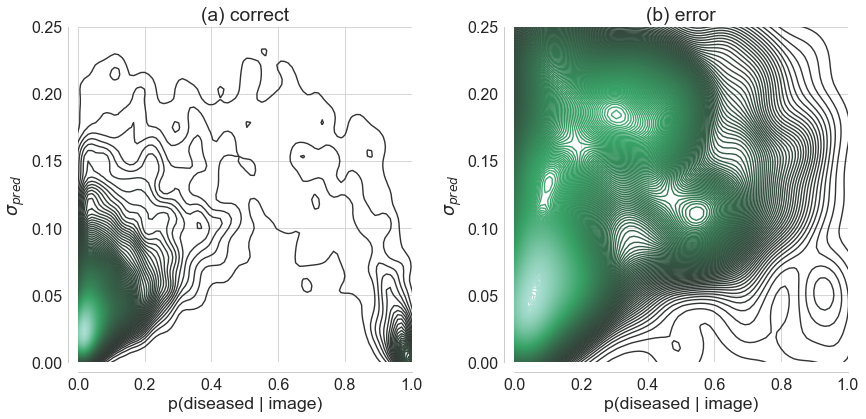

In [21]:
bayes_vs_softmax()

In [22]:
# ---------- Fig 3 ----------
def acc_rejection_figure(y, y_score, uncertainties, config,
                         save=False, format='.png', fig=None):
    if fig is None:
        fig = plt.figure(figsize=(FIGURE_WIDTH,
                                  FIGURE_WIDTH / 2.0))

    colors = sns.color_palette()

    ax121 = plt.subplot(1, 2, 1)
    ax122 = plt.subplot(1, 2, 2)
    ax121.set_title('(a)')
    ax122.set_title('(b)')

    min_acc = 1.0
    for i, (k, v) in enumerate(uncertainties.items()):
        v_tol, frac_retain, acc, acc_rand = \
            performance_over_uncertainty_tol(v, y, y_score, accuracy, 0.0,
                                             config['n_bootstrap'])
        ax121.plot(v_tol, acc['value'],
                   label=k, color=colors[i], linewidth=2)
        ax122.plot(frac_retain, acc['value'],
                   label=k, color=colors[i], linewidth=2)
        ax121.fill_between(v_tol, acc['value'], acc['low'],
                           color=colors[i], alpha=0.3)
        ax121.fill_between(v_tol, acc['high'], acc['value'],
                           color=colors[i], alpha=0.3)
        ax122.fill_between(frac_retain, acc['value'], acc['low'],
                           color=colors[i], alpha=0.3)
        ax122.fill_between(frac_retain, acc['high'], acc['value'],
                           color=colors[i], alpha=0.3)
        if min_acc > min(min(acc['low']), min(acc_rand['low'])):
            min_acc = min(min(acc['low']), min(acc_rand['low']))

    ax121.set_ylim(min_acc, 1)
    ax122.set_ylim(min_acc, 1)
    ax122.set_xlim(0.1, 1.0)
    ax121.set_xlabel('tolerated model uncertainty')
    ax121.set_ylabel('accuracy')
    ax121.legend(loc='best')

    ax122.plot(frac_retain, acc_rand['value'], label='random referral',
               color=colors[i+1], linewidth=2)
    ax122.fill_between(frac_retain, acc_rand['value'], acc_rand['low'],
                       color=colors[i+1], alpha=0.3)
    ax122.fill_between(frac_retain, acc_rand['high'], acc_rand['value'],
                       color=colors[i+1], alpha=0.3)
    ax122.set_xlabel('fraction of retained data')
    ax122.legend(loc='best')

    sns.despine(offset=10, trim=True)

    name = 'acc_' + config['net'] + '_' + str(config['disease_onset']) + \
           '_' + config['dataset']

    if save:
        fig.savefig(save_dir + name + format, bbox_inches='tight')

    return {name: fig}

In [23]:
# ---------- Main ----------
config = CONFIG['BCNN_moderateDR_Kaggle']

y = load_labels(config['LABELS_FILE'])
images = load_filenames(config['LABELS_FILE'])
probs, probs_mc = load_predictions(config['predictions'])
y_bin, probs_bin, probs_mc_bin = detection_task(
    y, probs, probs_mc, config['disease_onset'])
pred_mean, pred_std = posterior_statistics(probs_mc_bin)
uncertainties = {'$\sigma_{pred}$': pred_std}

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


{'acc_BCNN_2_Kaggle': <Figure size 893.16x446.58 with 2 Axes>}

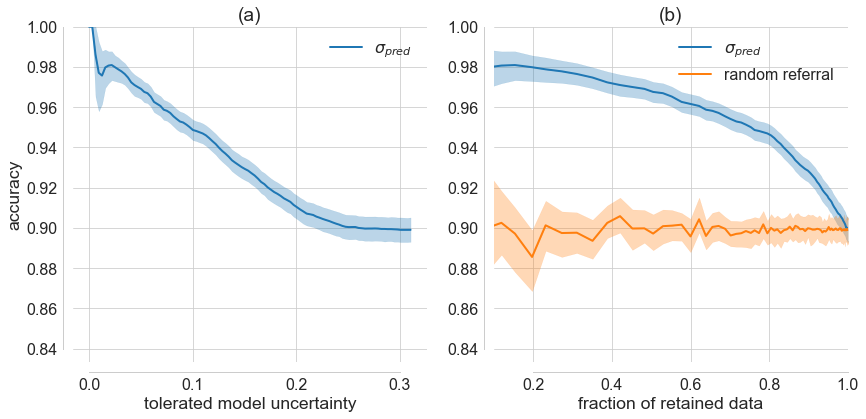

In [24]:
acc_rejection_figure(y_bin, pred_mean, uncertainties, config,
                     save=True, format='.png')

In [25]:
# ---------- Fig 6 ----------
def level_subplot(y_level, uncertainty, config,
                  ax=None):
    tol, frac_retain, accept_idx = sample_rejection(uncertainty, 0)
    LEVEL = config['LEVEL']
    p = {level: np.array([rel_freq(y_level[~accept], level)
                          for accept in accept_idx])
         for level in LEVEL}
    cum = np.zeros_like(tol)

    with sns.axes_style('white'):
        ax.set_title('Disease onset: %s'
                     % ONSET_TAG[config['disease_onset']])

        colors = {level: sns.color_palette("Blues")[level] for level in LEVEL}
        colors[0] = 'white'
        
        for level in LEVEL:
            ax.fill_between(tol, p[level] + cum, cum,
                            color=colors[level],
                            label='%d: %s' % (level, LEVEL[level]))
            if (level + 1) == config['disease_onset']:
                ax.plot(tol, p[level] + cum,
                        color='k', label='healthy/diseased boundary')
            cum += p[level]

        ax.set_xlim(min(tol), max(tol))
        ax.set_ylim(0, 1)

        ax.set_xlabel('tolerated model uncertainty')
        ax.set_ylabel('relative proportions within referred dataset')
        ax.legend(loc='lower left', prop={'size' : 12})


def level_figure(save=True):
    keys = ['BCNN_mildDR_Kaggle',
            'BCNN_moderateDR_Kaggle']
    title_prefix = ['(a)', '(b)']
    fig = plt.figure(figsize=(FIGURE_WIDTH, FIGURE_WIDTH / 2.0))
    for i, k in enumerate(keys):
        config = CONFIG[k]
        y = load_labels(config['LABELS_FILE'])
        probs, probs_mc = load_predictions(config['predictions'])
        _, _, probs_mc_bin = detection_task(y, probs, probs_mc,
                                            config['disease_onset'])
        _, pred_std = posterior_statistics(probs_mc_bin)

        ax = fig.add_subplot(1, 2, i + 1)
        level_subplot(y, pred_std, config, ax=ax)
        ax.set_title(title_prefix[i] + ' ' + ax.get_title())
        if i == 1:
            ax.set_ylabel('')
    
    if save:
        fig.savefig(save_dir + "level_figure.png", bbox_inches='tight')

    return {'level': fig}

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


{'level': <Figure size 893.16x446.58 with 2 Axes>}

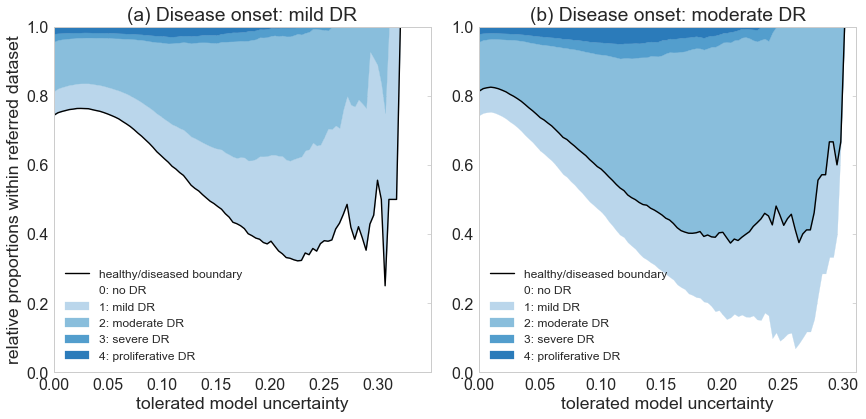

In [26]:
level_figure()

In [27]:
# ---------- Fig 4 ----------
def roc_auc_subplot(y, y_score, uncertainties, config,
                    save=False, format='.svg',
                    ax121=None, ax122=None):
    if ax121 is None or ax122 is None:
        fig = plt.figure(figsize=(FIGURE_WIDTH,
                                  FIGURE_WIDTH / 2.0))
        ax121 = plt.subplot2grid((1, 2), (0, 0))
        ax122 = plt.subplot2grid((1, 2), (0, 1))

    colors = sns.color_palette()

    ax121.set_title('(a) %s(onset: %s); %s'
                    % (config['net'], ONSET_TAG[config['disease_onset']],
                       config['dataset']))
    ax122.set_title('(b) %s(onset: %s); %s'
                    % (config['net'], ONSET_TAG[config['disease_onset']],
                       config['dataset']))

    for i, (k, v) in enumerate(uncertainties.items()):
        filename = 'predict_output/bt' + str(config['n_bootstrap']) + '_' + \
            k.replace(' ', '') + '_' + config['net'] + '_' + \
            str(config['disease_onset']) + '_' + config['dataset'] + '.npz'
        if os.path.exists(filename):
            data = np.load(filename)
            v_tol, frac_retain, auc, auc_rand = data['v_tol'], \
                data['frac_retain'], data['auc'], data['auc_rand']
        else:
            v_tol, frac_retain, auc, auc_rand = \
                performance_over_uncertainty_tol(v, y, y_score,
                                                 roc_auc_score,
                                                 config['min_percentile'],
                                                 config['n_bootstrap'])
            np.savez(filename, v_tol=v_tol, frac_retain=frac_retain,
                     auc=auc, auc_rand=auc_rand)

        ax121.plot(frac_retain, auc['value'],
                   label=k, color=colors[i], linewidth=2)
        ax121.fill_between(frac_retain, auc['value'], auc['low'],
                           color=colors[i], alpha=0.3)
        ax121.fill_between(frac_retain, auc['high'], auc['value'],
                           color=colors[i], alpha=0.3)
        # need v_tol sorted
        # v_tol.sort()
        print(v_tol)
        print(v)
        
        if k == 'MC dropout':
            # plot exemplary roc curves
            ax122
            fractions = [0.9, 0.8, 0.7]
            for j, f in enumerate(fractions):
                thr = v_tol[frac_retain >= f][0]
                print(thr)
                roc_curve_plot(y[v <= thr],
                               y_score[v <= thr],
                               color=colors[j+4],
                               legend_prefix='%d%% data retained, %s'
                               % (f * 100, k),
                               n_bootstrap=config['n_bootstrap'])


        # print confidence intervals for table 1
        fractions = [0.9, 0.8, 0.7]
        for j, f in enumerate(fractions):
            thr = v_tol[frac_retain >= f][0]
            low, high = bootstrap([y[v <= thr], y_score[v <= thr]],
                                  roc_auc_score,
                                  n_resamples=config['n_bootstrap'],
                                  alpha=0.05)
            roc_auc = roc_auc_score(y[v <= thr], y_score[v <= thr])
            msg = '%d%% data retained, %s' % (f * 100, k)
            msg += ' (auc:%0.3f; CI:%0.3f-%0.3f)' \
                % (roc_auc, low.value, high.value)
            print(msg)

    ax121.plot(frac_retain, auc_rand['value'],
               label='random referral', color=colors[i+1], linewidth=2)
    ax121.fill_between(frac_retain, auc_rand['value'], auc_rand['low'],
                       color=colors[i+1], alpha=0.3)
    ax121.fill_between(frac_retain, auc_rand['high'], auc_rand['value'],
                       color=colors[i+1], alpha=0.3)
    ax121.set_xlim(config['min_percentile'] / 100., 1.0)
    ax121.set_xlabel('retained data')
    ax121.set_ylabel('auc')
    ax121.legend(loc='best')

    ax122
    roc_curve_plot(y, y_score, color=colors[-1],
                   legend_prefix='no referral',
                   recommendation=True,
                   n_bootstrap=config['n_bootstrap'])

    x0, x1 = ax121.get_xlim()
    y0, y1 = ax121.get_ylim()
    ax121.set_aspect((x1 - x0) / (y1 - y0))
    x0, x1 = ax122.get_xlim()
    y0, y1 = ax122.get_ylim()
    ax122.set_aspect((x1 - x0) / (y1 - y0))

    if save and fig is not None:
        name = 'roc_' + config['net'] + '_' + str(config['disease_onset']) + \
            '_' + config['dataset']
        fig.savefig(name + format)
        return {name: fig}


def roc_auc_figure():
    keys = ['BCNN_mildDR_Kaggle',
            'BCNN_moderateDR_Kaggle',
            'BCNN_mildDR_Messidor',
            'BCNN_moderateDR_Messidor']
    titles = ['(a)', '(b)', '(c)', '(d)']
    fig = plt.figure()
    for i, k in enumerate(keys):
        config = CONFIG[k]
        print('Working on %s...' % k)
        y = load_labels(config['LABELS_FILE'])
        probs, probs_mc = load_predictions(config['predictions'])
        y_bin, probs_bin, probs_mc_bin = detection_task(
            y, probs, probs_mc, config['disease_onset'])
        pred_mean, pred_std = posterior_statistics(probs_mc_bin)
        uncertainties = {'MC dropout': pred_std,
                         'standard dropout': binary_entropy(probs_bin)}

        ax121 = plt.subplot(2, 4, 2 * i + 1)
        ax122 = plt.subplot(2, 4, 2 * i + 2)
        roc_auc_subplot(y_bin, pred_mean,
                        uncertainties, config,
                        save=False,
                        ax121=ax121,
                        ax122=ax122)
        ax121.set_title('')
        ax121.set_title(titles[i], loc='left')
        ax122.set_title('')
        ax122.set_xlim(0.0, 0.5)
        ax122.set_ylim(0.5, 1.0)

    sns.despine(offset=10)
    plt.tight_layout()

    return {'roc_auc': fig}


Working on BCNN_mildDR_Kaggle...
[0.08649728 0.08914622 0.09179516 0.0944441  0.09709304 0.09974199
 0.10239093 0.10503987 0.10768881 0.11033775 0.11298669 0.11563563
 0.11828457 0.12093351 0.12358245 0.12623139 0.12888033 0.13152928
 0.13417822 0.13682716 0.1394761  0.14212504 0.14477398 0.14742292
 0.15007186 0.1527208  0.15536974 0.15801868 0.16066762 0.16331657
 0.16596551 0.16861445 0.17126339 0.17391233 0.17656127 0.17921021
 0.18185915 0.18450809 0.18715703 0.18980597 0.19245491 0.19510386
 0.1977528  0.20040174 0.20305068 0.20569962 0.20834856 0.2109975
 0.21364644 0.21629538 0.21894432 0.22159326 0.22424221 0.22689115
 0.22954009 0.23218903 0.23483797 0.23748691 0.24013585 0.24278479
 0.24543373 0.24808267 0.25073161 0.25338055 0.2560295  0.25867844
 0.26132738 0.26397632 0.26662526 0.2692742  0.27192314 0.27457208
 0.27722102 0.27986996 0.2825189  0.28516784 0.28781679 0.29046573
 0.29311467 0.29576361 0.29841255 0.30106149 0.30371043 0.30635937
 0.30900831 0.31165725 0.31430

90% data retained, standard dropout (auc:0.895; CI:0.874-0.913)
80% data retained, standard dropout (auc:0.892; CI:0.869-0.913)
70% data retained, standard dropout (auc:0.901; CI:0.878-0.923)
no referral
Working on BCNN_moderateDR_Messidor...
[0.05841368 0.06111447 0.06381525 0.06651603 0.06921681 0.07191759
 0.07461837 0.07731916 0.08001994 0.08272072 0.0854215  0.08812228
 0.09082306 0.09352384 0.09622463 0.09892541 0.10162619 0.10432697
 0.10702775 0.10972853 0.11242932 0.1151301  0.11783088 0.12053166
 0.12323244 0.12593322 0.12863401 0.13133479 0.13403557 0.13673635
 0.13943713 0.14213791 0.14483869 0.14753948 0.15024026 0.15294104
 0.15564182 0.1583426  0.16104338 0.16374417 0.16644495 0.16914573
 0.17184651 0.17454729 0.17724807 0.17994886 0.18264964 0.18535042
 0.1880512  0.19075198 0.19345276 0.19615355 0.19885433 0.20155511
 0.20425589 0.20695667 0.20965745 0.21235823 0.21505902 0.2177598
 0.22046058 0.22316136 0.22586214 0.22856292 0.23126371 0.23396449
 0.23666527 0.2393660

<Figure size 432x288 with 0 Axes>

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


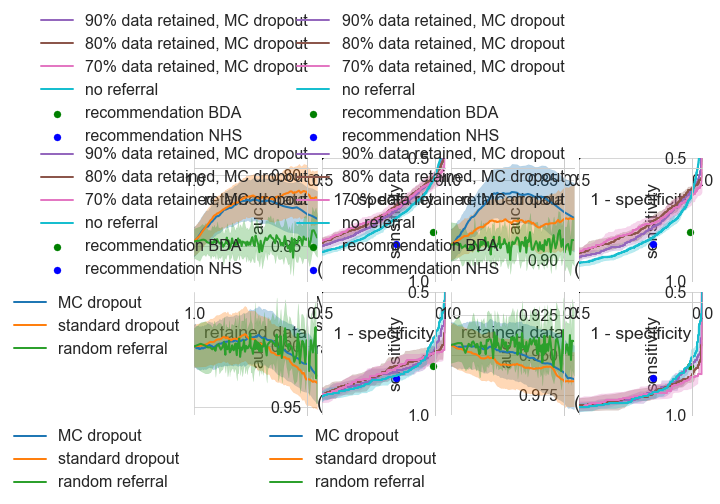

In [31]:
plt.tight_layout(False)

fig = roc_auc_figure()

In [ ]:
plt.tight_layout(False)
plt.figure(figsize=(10, 10))
fig['roc_auc']